# . Importing Libraries and Setting up Device:

In [ ]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

import the labires

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from PIL import Image
import PIL.ImageOps
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

# Setting up Device (Define the cuda or cpu)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Defining the Residual Block:

In [ ]:
# Create a ResidualBlock class
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

      # Foward function for the training

    def forward(self, x):
        out = self.left(x)
        out = out + self.shortcut(x)
        out = F.relu(out)

        return out

# Defining the ResNet Class:


In [ ]:
#Create the ReNet Class
class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Model Instantiation and Hyperparameters:


In [ ]:
def ResNet18():
    return ResNet(ResidualBlock)

In [ ]:
#set hyperparameter
EPOCH = 10
pre_epoch = 0
BATCH_SIZE = 128
LR = 0.001

#Data Loading and Preprocessing:


In [ ]:
#prepare dataset loading and preprocessing
transform_train = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307), (0.3081))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307), (0.3081))
])

#  Loading the Dataset

training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)

validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=128, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 342kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.62MB/s]


# Printing of the DataSet

In [ ]:
print(len(training_dataset))
print(len(validation_dataset))

60000
10000


# Image convertion

In [ ]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.squeeze()
  image = image * 0.5 + 0.5
  image = image.clip(0,1)
  return image

# Define the classes

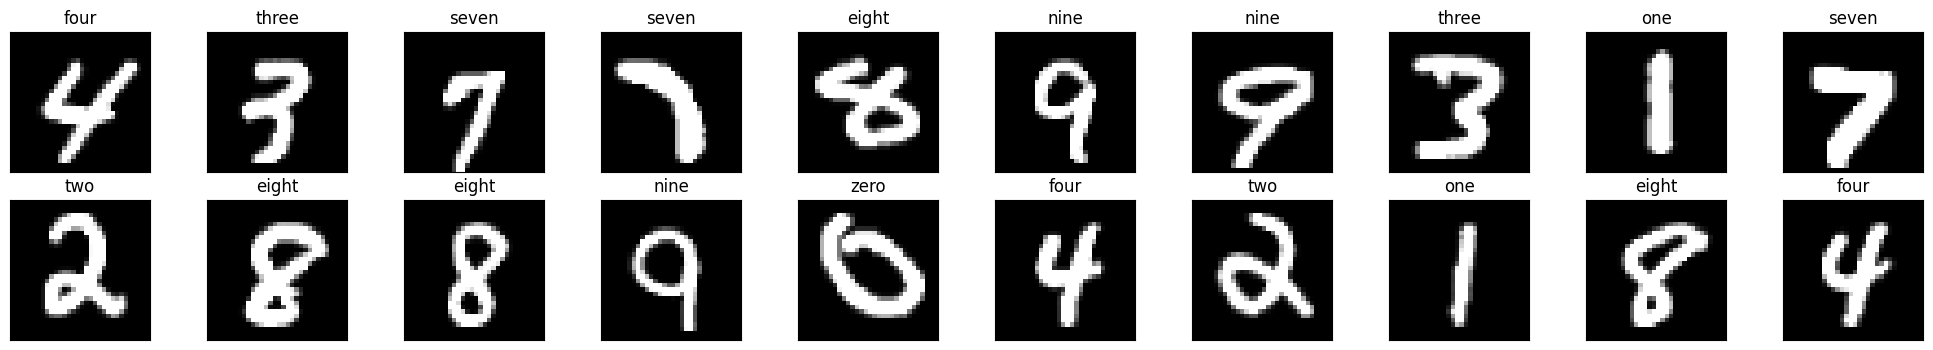

In [ ]:
classes = ('zero','one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

# Display images
training_loader_iter = iter(training_loader)
images, labels = next(training_loader_iter)

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx].cpu()), cmap='gray')
  ax.set_title(classes[labels[idx].item()])

# Model Training and Evaluation:

In [ ]:
def ResNet18():
        return ResNet(ResidualBlock)

In [ ]:
#define ResNet18
model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)

#Visualization and Results:

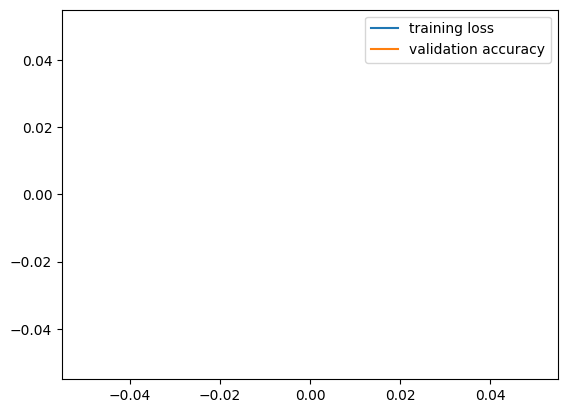

In [ ]:
# Here the graph show the TrainingLoss and the validation accuarcy
plt.plot(running_loss_histroy, label='training loss')
plt.plot([val.cpu() for val in val_running_corrects_history], label='validation accuracy')
plt.legend()

In [ ]:
running_loss_histroy = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for n in range(EPOCH):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)

    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/len(training_loader)
    running_loss_histroy.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print('EPOCH-OUT-PUT :', (n+1))
    print('training loss: {:.4f}, acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, val_acc {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))


EPOCH-OUT-PUT : 1
training loss: 0.3344, acc 116.6269
validation loss: 0.2718, val_acc 117.1899
EPOCH-OUT-PUT : 2
training loss: 0.0455, acc 126.4328
validation loss: 0.2338, val_acc 118.3291
EPOCH-OUT-PUT : 3
training loss: 0.0248, acc 127.1450
validation loss: 0.1813, val_acc 119.9114
EPOCH-OUT-PUT : 4
training loss: 0.0150, acc 127.5458
validation loss: 0.1574, val_acc 120.4051
EPOCH-OUT-PUT : 5
training loss: 0.0085, acc 127.7996
validation loss: 0.1522, val_acc 120.4430
EPOCH-OUT-PUT : 6
training loss: 0.0058, acc 127.8742
validation loss: 0.1374, val_acc 121.0253
EPOCH-OUT-PUT : 7
training loss: 0.0038, acc 127.9190
validation loss: 0.1312, val_acc 121.2785
EPOCH-OUT-PUT : 8
training loss: 0.0027, acc 127.9275
validation loss: 0.1315, val_acc 121.3671
EPOCH-OUT-PUT : 9
training loss: 0.0022, acc 127.9190
validation loss: 0.1274, val_acc 121.3798
EPOCH-OUT-PUT : 10
training loss: 0.0017, acc 127.9296
validation loss: 0.1260, val_acc 121.4937


Plot the traing history (Loss and Acc)

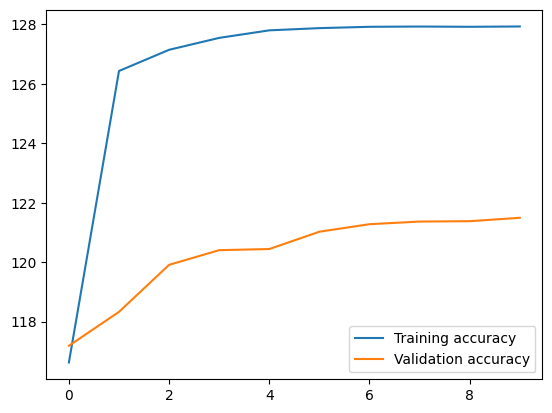

In [ ]:
# Here is the graph that show the Training accuracy and the validation accuracy
plt.plot([val.cpu() for val in running_corrects_history], label='Training accuracy')
plt.plot([val.cpu() for val in val_running_corrects_history], label='Validation accuracy')
plt.legend()

# Displaying of the trained images

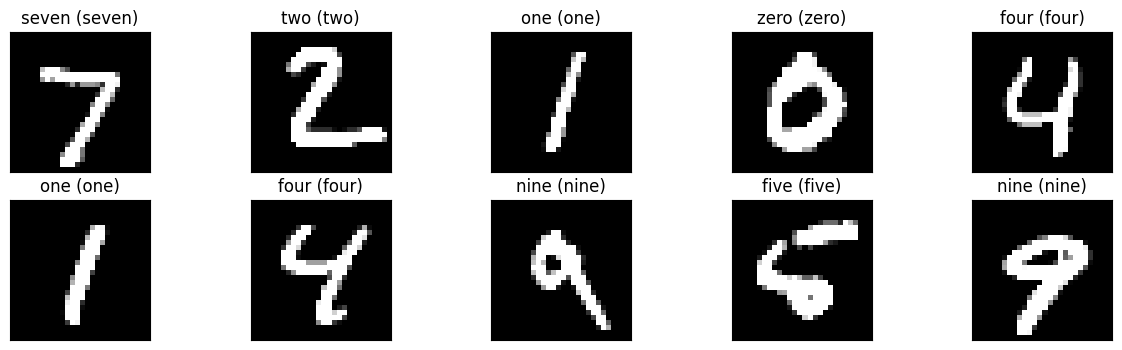

In [ ]:
# Display images with the validation lodder
training_loader_iter = iter(validation_loader)
images, labels = next(training_loader_iter)
images = images.to(device)
labels = labels.to(device)
images_ = images.view(images.shape[0], -1)
output = model(images)
_, preds = torch.max(output, 1)

# Create figure of the images displaced
fig = plt.figure(figsize=(15,4))
for idx in np.arange(10):
  ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx].cpu()), cmap='gray')
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()]), color = 'green' if preds[idx]==labels[idx] else 'red'))